# CTD Analysis

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cmocean
import numpy as np
from geopy import distance
import glob
import gsw
import warnings
import xarray as xr
import cftime
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean

In [125]:
ctd

<xarray.Dataset> Size: 1MB
Dimensions:      (trajectory: 24, obs: 1021)
Coordinates:
  * obs          (obs) int32 4kB 0 1 2 3 4 5 6 ... 1015 1016 1017 1018 1019 1020
  * trajectory   (trajectory) int64 192B 38 39 40 41 42 43 ... 56 57 58 59 60 61
Data variables:
    lat          (trajectory, obs) float32 98kB 5.03 5.03 5.03 ... nan nan nan
    lon          (trajectory, obs) float32 98kB 49.45 49.45 49.45 ... nan nan
    max_depth    (trajectory, obs) float32 98kB -2.776e+03 -2.776e+03 ... nan
    min_depth    (trajectory, obs) float32 98kB -11.0 -11.0 -11.0 ... nan nan
    raising      (trajectory, obs) float32 98kB 0.0 0.0 0.0 0.0 ... nan nan nan
    salinity     (trajectory, obs) float32 98kB 34.97 34.97 34.98 ... nan nan
    temperature  (trajectory, obs) float32 98kB 26.26 26.26 26.26 ... nan nan
    time         (trajectory, obs) datetime64[ns] 196kB 2024-09-17T23:12:00 ....
    winch_speed  (trajectory, obs) float32 98kB 1.0 1.0 1.0 1.0 ... nan nan nan
    z            (trajectory, obs) float32 98kB -11.0 -21.0 -31.0 ... nan nan
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        NewParticle_sample_salinity_sample_temperature_ct...
    parcels_mesh:           spherical
    parcels_version:        3.1.2

## Functions

In [262]:
def plots_S_T(ctd, title):

    vmin_s = 34.5
    vmax_s = 35.5
    vmin_t = 0
    vmax_t = 29
    vmin_d = 1026.5
    vmax_d = 1029.5
    
    # Create a figure with 1 row and 3 columns for subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'{title}', fontsize=14) 
    # Plot the trajectory on the first subplot (small figure)
    dens = axes[2].pcolormesh(ctd.s, ctd.depth,ctd.density.transpose(), label='Density [kg-m3]', cmap =  cmocean.cm.dense,clim=(vmin_d, vmax_d))
    axes[2].set_title("Density")
    axes[2].set_xlabel("distance from coast [km]")
    axes[2].set_ylabel("depth [m]")
    
    cbar =fig.colorbar(dens, ax=axes[2], label="Density [kg-m3]")
    #cbar.set_ticks(np.arange(vmin_d, vmax_d+0.5 ,0.5))
    
    # Plot salinity on the second subplot (large figure)
   
    salinity_plot = axes[0].pcolormesh(ctd.s, ctd.depth, ctd.salinity.transpose(), shading='nearest', clim= (vmin_s, vmax_s),cmap =  cmocean.cm.haline )
    axes[0].set_title("Salinity")
    axes[0].set_xlabel("distance from coast [km]")
    axes[0].set_ylabel("depth [m]")
    # Add colorbar for salinity plot
    cbar = fig.colorbar(salinity_plot, ax=axes[0], label="Salinity")
    #cbar.set_ticks(np.arange(vmin_s, vmax_s+0.2 ,0.2))
    
    # Plot temperature on the third subplot (large figure)
    temperature_plot = axes[1].pcolormesh(ctd.s, ctd.depth, ctd.temperature.transpose(), shading='nearest', clim=(vmin_t, vmax_t), cmap = cmocean.cm.thermal)
    axes[1].set_title("Temperature")
    axes[1].set_xlabel("distance from coast [km]")
    axes[1].set_ylabel("depth [m]")
    # Add colorbar for temperature plot
    cbar = fig.colorbar(temperature_plot, ax=axes[1], label="Temperature (°C)")
    #cbar.set_ticks(np.arange(vmin_t, vmax_t+0.5 ,0.5))
    # Adjust layout to ensure subplots are nicely spaced
    plt.tight_layout()
    plt.savefig(f'/Users/areti/OneDrive/Desktop/{title}_ctd.jpg',bbox_inches='tight',dpi=150, format='jpg')
    # Show the plot
    plt.show()

## Preparing the data

In [246]:
#loading the data
datadir = r'/Users/areti/Downloads/results2/somalia/results/ctd.zarr'
ctd = xr.open_zarr(datadir).compute()
ctd

<xarray.Dataset> Size: 1MB
Dimensions:      (trajectory: 24, obs: 1021)
Coordinates:
  * obs          (obs) int32 4kB 0 1 2 3 4 5 6 ... 1015 1016 1017 1018 1019 1020
  * trajectory   (trajectory) int64 192B 38 39 40 41 42 43 ... 56 57 58 59 60 61
Data variables:
    lat          (trajectory, obs) float32 98kB 5.03 5.03 5.03 ... nan nan nan
    lon          (trajectory, obs) float32 98kB 49.45 49.45 49.45 ... nan nan
    max_depth    (trajectory, obs) float32 98kB -2.776e+03 -2.776e+03 ... nan
    min_depth    (trajectory, obs) float32 98kB -11.0 -11.0 -11.0 ... nan nan
    raising      (trajectory, obs) float32 98kB 0.0 0.0 0.0 0.0 ... nan nan nan
    salinity     (trajectory, obs) float32 98kB 34.97 34.97 34.98 ... nan nan
    temperature  (trajectory, obs) float32 98kB 26.26 26.26 26.26 ... nan nan
    time         (trajectory, obs) datetime64[ns] 196kB 2024-09-17T23:12:00 ....
    winch_speed  (trajectory, obs) float32 98kB 1.0 1.0 1.0 1.0 ... nan nan nan
    z            (trajectory, obs) float32 98kB -11.0 -21.0 -31.0 ... nan nan
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        NewParticle_sample_salinity_sample_temperature_ct...
    parcels_mesh:           spherical
    parcels_version:        3.1.2

In [247]:
# take difference in obs direction
# during descent: diff < 0
dz = ctd.z.diff('obs') 
# using the 'diff' operator reduces the axis size by one
# copy dummy data (first obs entry of original array) to fill it up again
dz = xr.concat([dz.isel(obs=0),dz],dim='obs')
dz = dz.load()
dz['obs'] = np.arange(0,dz.obs.count()) # fixes bug where 'obs' index would occur double

In [248]:
# choose only the descent
ctd_descent = ctd.where(dz<0).compute()

#Cut off the nan entries that occur after a certain value obs_max
obs_max = int(ctd.z.argmin(dim='obs').max().compute())
ctd_descent = ctd_descent.isel(obs=slice(0,obs_max))

# find maximum depth over all the trajectories
traj_maxdepth = ctd.z.argmin(dim='obs').argmax(dim='trajectory').compute()
ctd_descent['obs'] = ctd_descent.z.isel(trajectory=traj_maxdepth)
ctd_descent = ctd_descent.rename({'obs':'depth'})


In [249]:
#indices for transects (south to north) 
trs1_idx = slice(0,8) #transect 1
trs2_idx = slice(8,16) #transect 2
trs3_idx = slice(16,24) #transect 3 

In [250]:
ctd_trs1 = ctd_descent.isel(trajectory=trs1_idx)
ctd_trs2 = ctd_descent.isel(trajectory=trs2_idx)
ctd_trs3 = ctd_descent.isel(trajectory=trs3_idx)

## Salinity and Temperature Plots

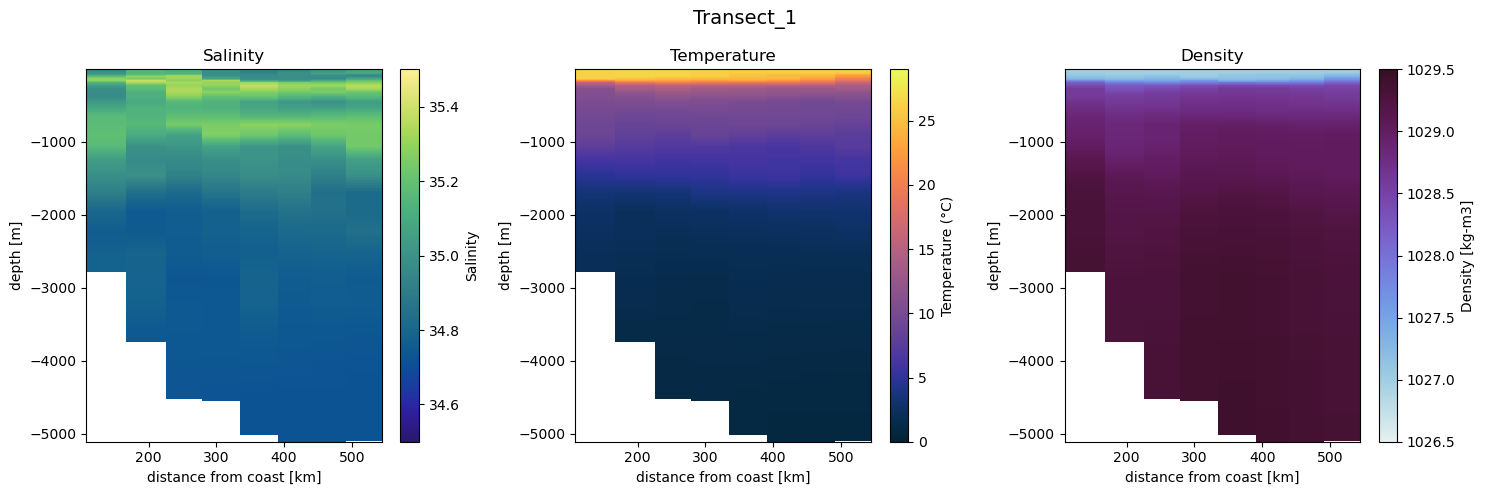

In [263]:
plots_S_T(ctd= ctd_trs1, title = 'Transect_1')

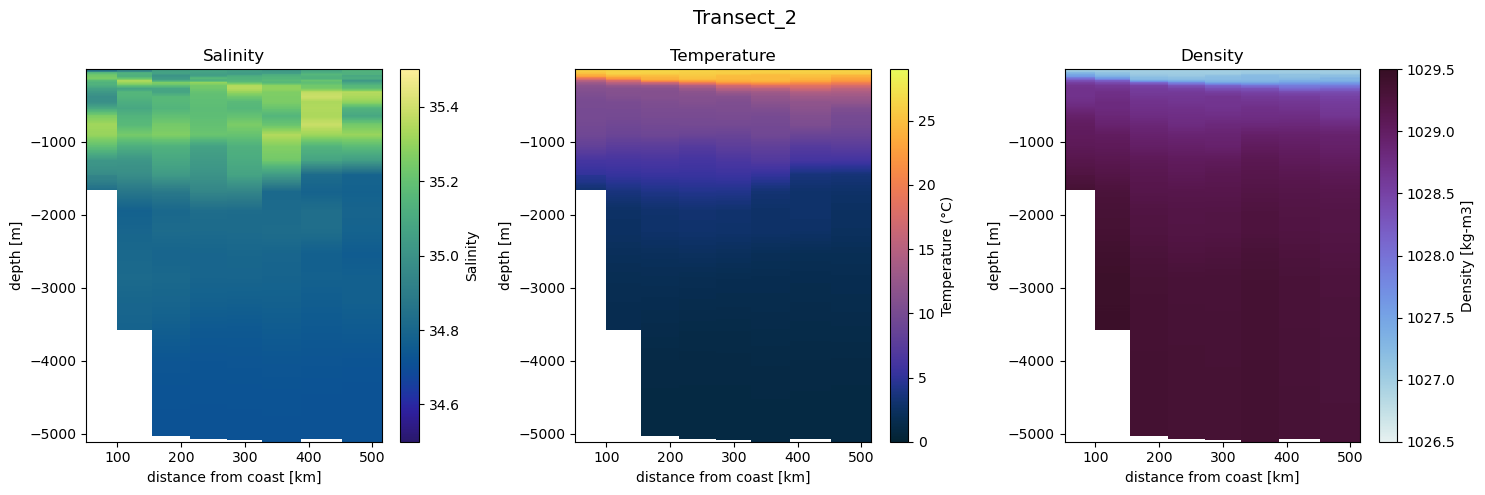

In [264]:
plots_S_T(ctd= ctd_trs2, title = 'Transect_2')

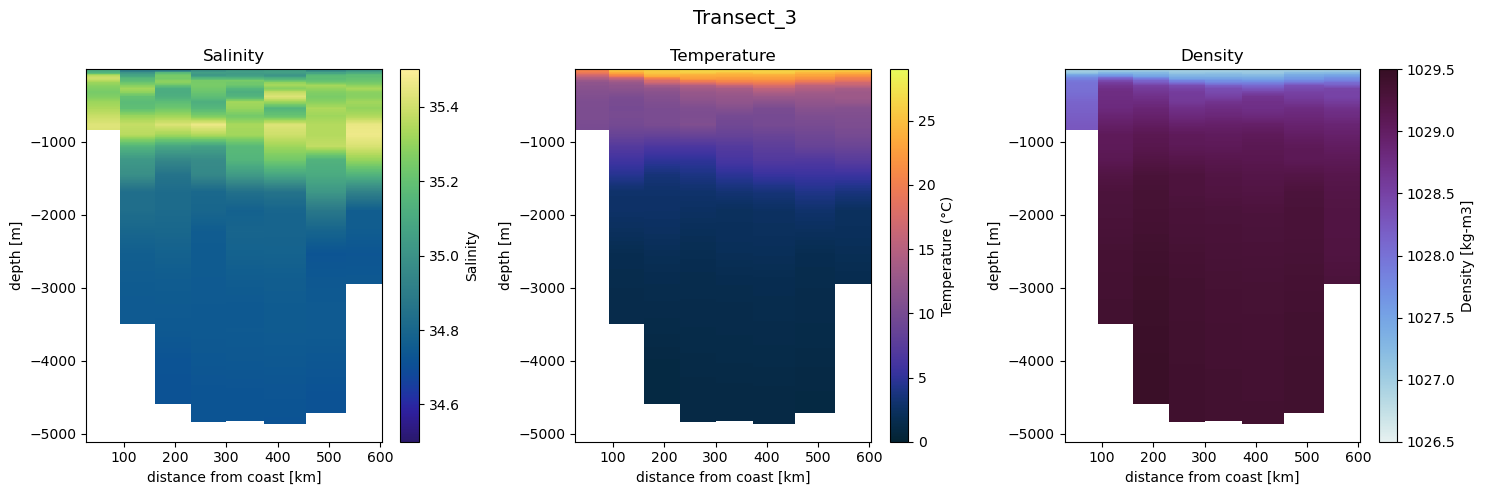

In [265]:
plots_S_T(ctd= ctd_trs3, title = 'Transect_3')

## Calculating density and velocity profiles 

In [251]:
# Constants
alpha_T = 1e-4  # Thermal expansion coefficient
beta_S = 7e-4   # Haline contraction coefficient
dens0 = 1027    # Reference density (kg/m³)

def calc_density(data ):
    """
    Calculate density from a profile containing salinity, temperature, and depth.
    Parameters:
        profile (dict): A dictionary containing 'salinity', 'temperature', 'z', and 'trajectory'.
    """
    S = data['salinity']
    T = data['temperature']
    depth = data['depth']

    # Reference salinity and temperature (surface value)
    S0 = S.isel(depth = 0)   #S[0] this selects the trajectory with index 0  
    T0 = T.isel(depth = 0)

    # Calculate density
    dens = dens0 * (1 - (alpha_T * (T - T0)) + (beta_S * (S - S0)))

    return dens

In [252]:
ctd_trs1['density'] = calc_density(ctd_trs1).assign_attrs({"long_name": "density", "units": "kg/m^3"})
ctd_trs2['density'] = calc_density(ctd_trs2).assign_attrs({"long_name": "density", "units": "kg/m^3"})
ctd_trs3['density'] = calc_density(ctd_trs3).assign_attrs({"long_name": "density", "units": "kg/m^3"})

## Plots 

In [253]:
#to calculate the distance from the shore later, I manually selected these points from the nioz tool. These are approximately the coordinades of the 
#shore if you extend our transects. 

#shore lon and lat (extension for transect 1)
lon_1_shore = 48.21
lat_1_shore = 4.97
#shore lon and lat (extension for transect 2)
lon_2_shore = 49.54
lat_2_shore = 7.29
#shore lon and lat (extension for transect 3)
lon_3_shore = 50.72
lat_3_shore = 9.31

In [254]:
def dist_shore(ctd, lon0,lat0):   # Calculate the distance from each measurement to the coast and add it as variable to the dataset.
    #adcp_surf = adcp.isel(trajectory=0).compute()
    ctd_surf = ctd.isel(depth=0).compute()
    #d = xr.zeros_like(adcp_surf.lon)
    d2 = xr.zeros_like(ctd_surf.lon)
    #lon0, lat0 = adcp_surf.lon.data[-1], adcp_surf.lat.data[-1]
    #for ob, (lon, lat) in enumerate(zip(adcp_surf.lon.data, adcp_surf.lat.data)):
    #    d[ob] = distance.distance((lon, lat), (lon0, lat0)).km
    #    adcp["s"] = d.assign_attrs(
    #    {"long_name": "distance to coast", "units": "km", "positive": "off shore"}
    #)
    for ob, (lon, lat) in enumerate(zip(ctd_surf.lon.data, ctd_surf.lat.data)):
        d2[ob] = distance.distance((lon, lat), (lon0, lat0)).km
        ctd["s"] = d2.assign_attrs(
        {"long_name": "distance to coast", "units": "km", "positive": "on shore"}
    )
    #adcp = adcp.set_coords("s").sortby("s")
    ctd  = ctd.set_coords("s").sortby("s")
    #print(f"max distance from coast: {abs(adcp.s.min()).data / 1000:.2f} km")
    return ctd

In [255]:
ctd_trs1 = dist_shore( ctd = ctd_trs1, lon0=lon_1_shore,lat0=lat_1_shore)
ctd_trs2 = dist_shore(ctd = ctd_trs2, lon0=lon_2_shore,lat0=lat_2_shore)
ctd_trs3 = dist_shore(ctd= ctd_trs3, lon0=lon_3_shore,lat0=lat_3_shore)

In [256]:
salinity_expanded.shape

(8, 512)

C:\Users\areti\AppData\Local\Temp\ipykernel_10572\3375403510.py:12: UserWarning: The following kwargs were not used by contour: 'shading'
  dens_plot = plt.contourf(data.s, data.depth, data.density.transpose(), shading='nearest', cmap= cmocean.cm.dense, levels = np.linspace(vmin,vmax,30))
C:\Users\areti\AppData\Local\Temp\ipykernel_10572\3375403510.py:14: UserWarning: The following kwargs were not used by contour: 'label'
  therm = plt.contour(data.s, data.depth, data.temperature.transpose(),  colors='black', linewidths=1.2, linestyles='-', label = 'Temperature (°C)', zorder=1)
C:\Users\areti\AppData\Local\Temp\ipykernel_10572\3375403510.py:17: UserWarning: The following kwargs were not used by contour: 'label'
  sal = plt.contour(data.s, data.depth, data.salinity.transpose(),  colors='orange', linewidths=1.2, linestyles='--', levels=np.arange(34,36,0.25), label = 'Salinity', zorder=2)


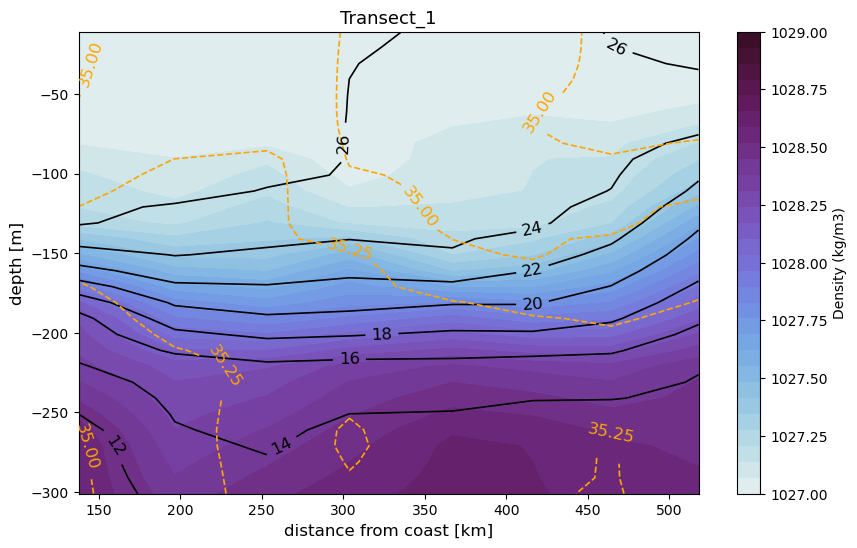

In [299]:
data = ctd_trs1.sel(depth=slice(-11,-301))
vmin = 1027
vmax = 1029
fontsize = 12
inline =0.8
inline_sp = 10
linewidth=3
fig = plt.figure(figsize=(10,6))
lons = ctd_trs1.lon.isel(depth=0)
depths = ctd_trs1.depth
# density
dens_plot = plt.contourf(data.s, data.depth, data.density.transpose(), shading='nearest', cmap= cmocean.cm.dense, levels = np.linspace(vmin,vmax,30))
#
therm = plt.contour(data.s, data.depth, data.temperature.transpose(),  colors='black', linewidths=1.2, linestyles='-', label = 'Temperature (°C)', zorder=1)
plt.clabel(therm,inline= inline,fontsize = fontsize,colors='black',inline_spacing = inline_sp,zorder=3)

sal = plt.contour(data.s, data.depth, data.salinity.transpose(),  colors='orange', linewidths=1.2, linestyles='--', levels=np.arange(34,36,0.25), label = 'Salinity', zorder=2)
plt.clabel(sal,inline= inline,fontsize = fontsize,colors='orange',inline_spacing = inline_sp,zorder=3)

plt.title("Transect_1",fontsize =  13)
plt.xlabel("distance from coast [km]",fontsize = fontsize)
plt.ylabel("depth [m]",fontsize = fontsize)
# Add colorbar for temperature plot
cbar = plt.colorbar(dens_plot, label="Density (kg/m3)")
cbar.set_ticks(np.arange(1027, 1029.25 ,0.25))
plt.savefig(r'/Users/areti/OneDrive/Desktop/combo_Transect1.jpg',bbox_inches='tight',dpi=150, format='jpg')


In [107]:
ctd_trs1

<xarray.Dataset> Size: 198kB
Dimensions:      (trajectory: 8, depth: 510)
Coordinates:
  * depth        (depth) float32 2kB -11.0 -21.0 -31.0 ... -5.091e+03 -5.101e+03
  * trajectory   (trajectory) int64 64B 38 39 40 41 42 43 44 45
    s            (trajectory) float32 32B 137.7 196.8 253.4 ... 464.3 517.8
Data variables:
    lat          (trajectory, depth) float32 16kB 5.03 5.03 5.03 ... 4.854 nan
    lon          (trajectory, depth) float32 16kB 49.45 49.45 ... 52.86 nan
    max_depth    (trajectory, depth) float32 16kB -2.776e+03 -2.776e+03 ... nan
    min_depth    (trajectory, depth) float32 16kB -11.0 -11.0 ... -11.0 nan
    raising      (trajectory, depth) float32 16kB 0.0 0.0 0.0 ... 0.0 1.0 nan
    salinity     (trajectory, depth) float32 16kB 34.97 34.97 ... 34.72 nan
    temperature  (trajectory, depth) float32 16kB 26.26 26.26 ... 0.8882 nan
    time         (trajectory, depth) datetime64[ns] 33kB 2024-09-17T23:12:00 ...
    winch_speed  (trajectory, depth) float32 16kB 1.0 1.0 1.0 ... 1.0 1.0 nan
    z            (trajectory, depth) float32 16kB -11.0 -21.0 ... -5.091e+03 nan
    density      (trajectory, depth) float32 16kB 1.027e+03 1.027e+03 ... nan
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        NewParticle_sample_salinity_sample_temperature_ct...
    parcels_mesh:           spherical
    parcels_version:        3.1.2

C:\Users\areti\AppData\Local\Temp\ipykernel_10572\2848798479.py:11: UserWarning: The following kwargs were not used by contour: 'shading'
  dens_plot = plt.contourf(data.s, data.depth, data.density.transpose(), shading='nearest', cmap= cmocean.cm.dense, levels = np.linspace(vmin,vmax,30))
C:\Users\areti\AppData\Local\Temp\ipykernel_10572\2848798479.py:13: UserWarning: The following kwargs were not used by contour: 'label'
  therm = plt.contour(data.s, data.depth, data.temperature.transpose(),  colors='black', linewidths=1.2, linestyles='-', label = 'Temperature (°C)', zorder=1)
C:\Users\areti\AppData\Local\Temp\ipykernel_10572\2848798479.py:16: UserWarning: The following kwargs were not used by contour: 'label'
  sal = plt.contour(data.s, data.depth, data.salinity.transpose(),  colors='orange', linewidths=1.2, linestyles='--', levels=np.arange(34,36,0.25), label = 'Salinity', zorder=2)


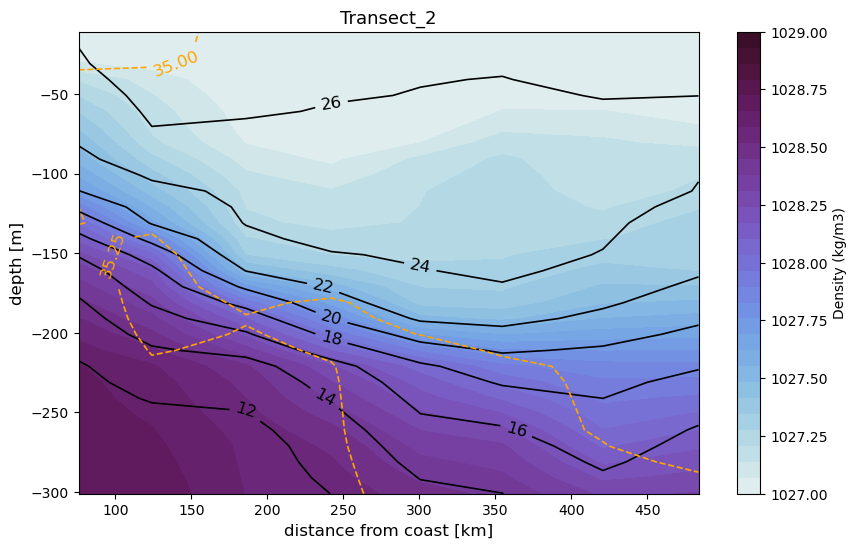

In [297]:
data = ctd_trs2.sel(depth=slice(-11,-301))
vmin = 1027
vmax = 1029
fontsize = 12
inline =0.8
inline_sp = 10
linewidth=3
fig = plt.figure(figsize=(10,6))

# density
dens_plot = plt.contourf(data.s, data.depth, data.density.transpose(), shading='nearest', cmap= cmocean.cm.dense, levels = np.linspace(vmin,vmax,30))
#
therm = plt.contour(data.s, data.depth, data.temperature.transpose(),  colors='black', linewidths=1.2, linestyles='-', label = 'Temperature (°C)', zorder=1)
plt.clabel(therm,inline= inline,fontsize = fontsize,colors='black',inline_spacing = inline_sp,zorder=3)

sal = plt.contour(data.s, data.depth, data.salinity.transpose(),  colors='orange', linewidths=1.2, linestyles='--', levels=np.arange(34,36,0.25), label = 'Salinity', zorder=2)
plt.clabel(sal,inline= inline,fontsize = fontsize,colors='orange',inline_spacing = inline_sp,zorder=3)

plt.title("Transect_2",fontsize =  13)
plt.xlabel("distance from coast [km]",fontsize = fontsize)
plt.ylabel("depth [m]",fontsize = fontsize)
# Add colorbar for temperature plot
cbar = plt.colorbar(dens_plot, label="Density (kg/m3)")
cbar.set_ticks(np.arange(1027, 1029.25 ,0.25))
plt.savefig(r'/Users/areti/OneDrive/Desktop/combo_Transect2.jpg',bbox_inches='tight',dpi=150, format='jpg')

C:\Users\areti\AppData\Local\Temp\ipykernel_10572\4055095067.py:11: UserWarning: The following kwargs were not used by contour: 'shading'
  dens_plot = plt.contourf(data.s, data.depth, data.density.transpose(), shading='nearest', cmap= cmocean.cm.dense, levels = np.linspace(vmin,vmax,30))
C:\Users\areti\AppData\Local\Temp\ipykernel_10572\4055095067.py:13: UserWarning: The following kwargs were not used by contour: 'label'
  therm = plt.contour(data.s, data.depth, data.temperature.transpose(),  colors='black', linewidths=1.2, linestyles='-', label = 'Temperature (°C)', zorder=1)
C:\Users\areti\AppData\Local\Temp\ipykernel_10572\4055095067.py:16: UserWarning: The following kwargs were not used by contour: 'label'
  sal = plt.contour(data.s, data.depth, data.salinity.transpose(),  colors='orange', linewidths=1.2, linestyles='--', levels=np.arange(34,36,0.25), label = 'Salinity', zorder=2)


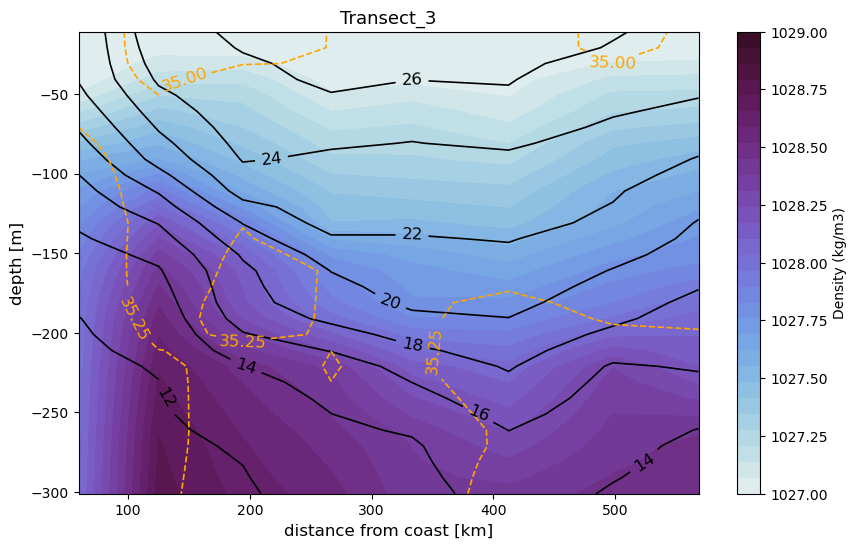

In [298]:
data = ctd_trs3.sel(depth=slice(-11,-301))
vmin = 1027
vmax = 1029
fontsize = 12
inline =0.8
inline_sp = 10
linewidth=3
fig = plt.figure(figsize=(10,6))

# density
dens_plot = plt.contourf(data.s, data.depth, data.density.transpose(), shading='nearest', cmap= cmocean.cm.dense, levels = np.linspace(vmin,vmax,30))
#
therm = plt.contour(data.s, data.depth, data.temperature.transpose(),  colors='black', linewidths=1.2, linestyles='-', label = 'Temperature (°C)', zorder=1)
plt.clabel(therm,inline= inline,fontsize = fontsize,colors='black',inline_spacing = inline_sp,zorder=3)

sal = plt.contour(data.s, data.depth, data.salinity.transpose(),  colors='orange', linewidths=1.2, linestyles='--', levels=np.arange(34,36,0.25), label = 'Salinity', zorder=2)
plt.clabel(sal,inline= inline,fontsize = fontsize,colors='orange',inline_spacing = inline_sp,zorder=3)

plt.title("Transect_3",fontsize =  13)
plt.xlabel("distance from coast [km]",fontsize = fontsize)
plt.ylabel("depth [m]",fontsize = fontsize)
# Add colorbar for temperature plot
cbar = plt.colorbar(dens_plot, label="Density (kg/m3)")
cbar.set_ticks(np.arange(1027, 1029.25 ,0.25))
plt.savefig(r'/Users/areti/OneDrive/Desktop/combo_Transect3.jpg',bbox_inches='tight',dpi=150, format='jpg')

In [ ]:
#densities at each stop
for i in range(8):
    plt.plot(dens[i], depths)

In [ ]:
ctd = ctd_descent.isel(trajectory=trs1_idx)
ctd['density'] = dens.assign_attrs({"long_name": "Density", "units": "m/kg 3"})
